In [ ]:
!pip install geopy
!pip install emoji

In [1]:
import re
import time
import folium
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from emoji import core
from scipy import stats
from bs4 import BeautifulSoup
from selenium import webdriver
from konlpy.tag import Komoran
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from geopy.geocoders import Nominatim
from selenium.webdriver.common.by import By
from collections import Counter,defaultdict
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.chrome.service import Service
from sklearn.metrics.pairwise import cosine_similarity
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import ElementClickInterceptedException

plt.rc('font',family = 'Malgun Gothic')

In [ ]:
# 호텔명, url 가져오기

service = Service(executable_path='./chromedriver.exe')
driver = webdriver.Chrome(service=service)
url = "https://www.agoda.com/ko-kr/search?city=14690&checkIn=2023-12-29&los=1&rooms=1&adults=2&children=0&locale=ko-kr&ckuid=3298c6b4-c27f-4698-86c9-8a0af3e523bb&prid=0&gclid=Cj0KCQiAm4WsBhCiARIsAEJIEzX0PxKz5s9dsRAqZCCagu1R1EfBiD5SLOIvD5ME-4u28z5kjBVPAEEaAjj_EALw_wcB&currency=KRW&correlationId=8402090a-d1d7-455e-9a8f-086930b85077&analyticsSessionId=-1315171232710586634&pageTypeId=5&realLanguageId=9&languageId=9&origin=KR&cid=1891463&tag=45b17d1d-e0b0-fe2a-ce90-5513829d856b&userId=3298c6b4-c27f-4698-86c9-8a0af3e523bb&whitelabelid=1&loginLvl=0&storefrontId=3&currencyId=26&currencyCode=KRW&htmlLanguage=ko-kr&cultureInfoName=ko-kr&machineName=hk-geoweb-2004&trafficGroupId=5&sessionId=5e3l543y1jb4yppwktzzxuko&trafficSubGroupId=122&aid=82361&useFullPageLogin=true&cttp=4&isRealUser=true&mode=production&browserFamily=Chrome&cdnDomain=agoda.net&checkOut=2023-12-30&priceCur=KRW&textToSearch=%EC%84%9C%EC%9A%B8&travellerType=1&familyMode=off&ds=TIxA8l233xaGM%2Fhi&hotelStarRating=4&hotelAccom=34&productType=-1"
driver.get(url)
time.sleep(2)

#element = driver.find_element(By.CSS_SELECTOR,"Autocomplete_txt__nb6wT").click()
#titles = drive.find_element(By.CSS_SELECTOR, 'div.box_headline a.link_txt').text # (.)은 클래스를 나타냄
#print(titles)

# driver.quit()

actions = ActionChains(driver)
last_height = driver.execute_script('return document.body.scrollHeight')
while True:
    for _ in range (10):
        actions.send_keys(Keys.SPACE).perform()
        time.sleep(1)
    new_height = driver.execute_script('return document.body.scrollHeight')
    if new_height == last_height:
        break
    last_height = new_height

hotels_raw = driver.find_elements(By.CLASS_NAME, "PropertyCard__Link")


hotels_url_list =[]
hotels_names_list=[]
hotels_location_list=[]
hotels_star_list=[]
hotels_rate_list=[]
for i in range(len(hotels_raw)):
    hotels_url_list.append(hotels_raw[i].get_attribute('href'))
    hotels_names_list.append(hotels_raw[i].get_attribute('aria-label'))

In [ ]:
df = pd.DataFrame({
    "hotel_name": hotels_names_list,
    "hotel_star":None,
    "hotel_rate":None,
    "hotel_url": hotels_url_list,
    "hotel_location": None,
    "review": None
})

In [ ]:
df.to_csv('./data/hotel_5star_agoda.csv',encoding='utf-8')

===================================================

5성급 호텔 크롤링

별점, 리뷰, 주소

In [ ]:
df = pd.read_csv('./data/hotel_5star_agoda.csv')
df.head()

In [ ]:
df['review'] = None
df

In [ ]:
urls = df['hotel_url'].tolist()
len(urls)

In [92]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

In [ ]:
reviews = []

for i in range(9,11):
    # 호텔 url 들어가기 
    driver.get(urls[i])
    time.sleep(5)
    
    # 언어 변경
    try:
        language_dropdown = Select(driver.find_element(By.CSS_SELECTOR, '#reviewFilterSection > div.sc-bdfBwQ.sc-gsTCUz.gdcQLK > div.sc-bdfBwQ.sc-gsTCUz.djZOQg > div > div > label > div.sc-bdfBwQ.sc-gsTCUz.bqqCNI > span > select'))
        # driver.find_element(By.XPATH, '//*[@id="reviewFilterSection"]/div[1]/div[3]/span/i[2]').click() #21번 전까지
        time.sleep(1)
    except ElementClickInterceptedException:
        continue
    
    # "한국어"를 선택
    try:
        language_dropdown.select_by_visible_text("한국어")
        # driver.find_element(By.XPATH, '//*[@id="reviews-language-filter_list"]/ul/li[2]').click() # 21번 전까지
        time.sleep(1)
    except ElementClickInterceptedException:
        continue
    
    while True:
        star_elements = driver.find_elements(By.CLASS_NAME, 'Review-comment-leftScore')
        review_elements = driver.find_elements(By.CLASS_NAME, 'Review-comment-bodyText')

        for star_element, review_element in zip(star_elements, review_elements):
            score = star_element.text
            review = review_element.text
            reviews.append([score, review])

        # 페이지 넘기기
        try:
            driver.find_element('xpath','//*[@id="reviewSection"]/div[4]/div/span[3]/i').click()
            time.sleep(1)
        except ElementClickInterceptedException:
            # 다음 페이지가 없으면 while 루프 종료
            break
        except NoSuchElementException:
            break
        
    df.at[i,'review'] = reviews
    reviews = []
    
    time.sleep(160)
    continue

In [ ]:
for i in range(len(urls)):
    review_column = df.iloc[i]['review']
    
    if review_column is not None:
        print(f'{i}번째 : ', len(review_column))
    else:
        print(f'{i}번째 : None.')

In [ ]:
for i in range(61,len(urls)):
    # 호텔 url 들어가기 
    driver.get(urls[i])
    time.sleep(2)
    
    # 홈페이지 총점 가져오기
    stars = float(driver.find_element('xpath','//*[@id="property-critical-root"]/div/div[5]/div[2]/div[1]/div[1]/div/div[1]/div/div/div/div/div/div/p[1]').text)
    df_3star.at[i,'hotel_rate'] = stars
        
    # 주소
    address = driver.find_element('xpath','//*[@id="property-main-content"]/div[1]/div[2]/div[2]/span[1]').text
    df_3star.at[i,'hotel_location'] = address
    
    
    # 성급
    star = driver.find_elements(By.CSS_SELECTOR,
                                    "#property-main-content > div.Box-sc-kv6pi1-0.cJiLOx.sc-gGmIRh.iyCRmc > div.HeaderCerebrum > div:nth-child(1) > div > span")
    if star:
        df_3star.at[i, "hotel_star"] = star[0].get_attribute('aria-label')
    else:
        df_3star.at[i, "hotel_star"] = None


In [ ]:
df.to_csv('./data/hotel_5star_agoda_add.csv',index=False,encoding='utf-8')

=========================================


4성급 호텔

리뷰, 평점, 주소


In [ ]:
df_4star = pd.read_csv('./data/hotel_4star_agoda.csv')
df_4star.head()

In [ ]:
df_4star['review'] = None
df_4star.tail()

In [ ]:
urls = df_4star['hotel_url'].tolist()
len(urls)

In [ ]:
reviews = []

a = 105
b = 105
l = len(urls)

for i in range(a,l):
    # 호텔 url 들어가기 
    driver.get(urls[i])
    time.sleep(5)
    
    # 언어 변경
    try:
        language_dropdown = Select(driver.find_element(By.CSS_SELECTOR, '#reviewFilterSection > div.sc-bdfBwQ.sc-gsTCUz.gdcQLK > div.sc-bdfBwQ.sc-gsTCUz.djZOQg > div > div > label > div.sc-bdfBwQ.sc-gsTCUz.bqqCNI > span > select'))
        # driver.find_element(By.XPATH, '//*[@id="reviewFilterSection"]/div[1]/div[3]/span').click() #21번 전까지
        time.sleep(1)
    except ElementClickInterceptedException:
        continue

    # "한국어"를 선택
    try:
        language_dropdown.select_by_visible_text("한국어")
        # driver.find_element(By.XPATH, '//*[@id="reviews-language-filter_list"]/ul/li[3]').click() # 21번 전까지
        time.sleep(1)
    except ElementClickInterceptedException:
        continue
    
    while True:
        star_elements = driver.find_elements(By.CLASS_NAME, 'Review-comment-leftScore')
        review_elements = driver.find_elements(By.CLASS_NAME, 'Review-comment-bodyText')

        for star_element, review_element in zip(star_elements, review_elements):
            score = star_element.text
            review = review_element.text
            reviews.append([score, review])

        # 페이지 넘기기
        try:
            driver.find_element('xpath','//*[@id="reviewSection"]/div[4]/div/span[3]/i').click()
            time.sleep(1)
        except ElementClickInterceptedException:
            # 다음 페이지가 없으면 while 루프 종료
            break
        except NoSuchElementException:
            break
        
    df_4star.at[i,'review'] = reviews
    reviews = []
    
    time.sleep(120)

In [ ]:
for i in range(len(urls)):
    review_column = df_4star.iloc[i]['review']
    
    if review_column is not None:
        print(f'{i}번째 : ', len(review_column))
    else:
        print(f'{i}번째 : None.')

In [ ]:
for i in range(61,len(urls)):
    # 호텔 url 들어가기 
    driver.get(urls[i])
    time.sleep(2)
    
    # 홈페이지 총점 가져오기
    stars = float(driver.find_element('xpath','//*[@id="property-critical-root"]/div/div[5]/div[2]/div[1]/div[1]/div/div[1]/div/div/div/div/div/div/p[1]').text)
    df_3star.at[i,'hotel_rate'] = stars
        
    # 주소
    address = driver.find_element('xpath','//*[@id="property-main-content"]/div[1]/div[2]/div[2]/span[1]').text
    df_3star.at[i,'hotel_location'] = address
    
    
    # 성급
    star = driver.find_elements(By.CSS_SELECTOR,
                                    "#property-main-content > div.Box-sc-kv6pi1-0.cJiLOx.sc-gGmIRh.iyCRmc > div.HeaderCerebrum > div:nth-child(1) > div > span")
    if star:
        df_3star.at[i, "hotel_star"] = star[0].get_attribute('aria-label')
    else:
        df_3star.at[i, "hotel_star"] = None


In [ ]:
df_4star.to_csv('./data/hotel_4star_agoda_add.csv',index=False,encoding='utf-8')

=======================

3성급

리뷰, 평점, 주소

In [ ]:
df_3star = pd.read_csv('./data/hotel_3star_agoda.csv')

In [ ]:
df_3star['review'] = None

In [ ]:
urls = df_3star['hotel_url'].tolist()

In [ ]:
reviews = []

a = 113
b = 60
l = len(urls)

for i in range(l-1,l):
    # 호텔 url 들어가기 
    driver.get(urls[i])
    time.sleep(5)
    
    
    # 언어 변경
    try:
        language_dropdown = Select(driver.find_element(By.CSS_SELECTOR, '#reviewFilterSection > div.sc-bdfBwQ.sc-gsTCUz.gdcQLK > div.sc-bdfBwQ.sc-gsTCUz.djZOQg > div > div > label > div.sc-bdfBwQ.sc-gsTCUz.bqqCNI > span > select'))
        # driver.find_element(By.XPATH, '//*[@id="reviewFilterSection"]/div[1]/div[3]/span').click() #21번 전까지
        time.sleep(1)
    except ElementClickInterceptedException:
        continue

    # "한국어"를 선택
    try:
        language_dropdown.select_by_visible_text("한국어")
        # driver.find_element(By.XPATH, '//*[@id="reviews-language-filter_list"]/ul/li[3]').click() # 21번 전까지
        time.sleep(1)
    except ElementClickInterceptedException:
        continue
    
    while True:
        star_elements = driver.find_elements(By.CLASS_NAME, 'Review-comment-leftScore')
        review_elements = driver.find_elements(By.CLASS_NAME, 'Review-comment-bodyText')

        for star_element, review_element in zip(star_elements, review_elements):
            score = star_element.text
            review = review_element.text
            reviews.append([score, review])

        # 페이지 넘기기
        try:
            driver.find_element('xpath','//*[@id="reviewSection"]/div[4]/div/span[3]/i').click()
            time.sleep(1)
        except ElementClickInterceptedException:
            # 다음 페이지가 없으면 while 루프 종료
            break
        except NoSuchElementException:
            break
        
    df_3star.at[i,'review'] = reviews
    reviews = []
    
    time.sleep(120)

In [ ]:
for i in range(61,len(urls)):
    # 호텔 url 들어가기 
    driver.get(urls[i])
    time.sleep(2)
    
    # 홈페이지 총점 가져오기
    stars = float(driver.find_element('xpath','//*[@id="property-critical-root"]/div/div[5]/div[2]/div[1]/div[1]/div/div[1]/div/div/div/div/div/div/p[1]').text)
    df_3star.at[i,'hotel_rate'] = stars
        
    # 주소
    address = driver.find_element('xpath','//*[@id="property-main-content"]/div[1]/div[2]/div[2]/span[1]').text
    df_3star.at[i,'hotel_location'] = address
    
    
    # 성급
    star = driver.find_elements(By.CSS_SELECTOR,
                                    "#property-main-content > div.Box-sc-kv6pi1-0.cJiLOx.sc-gGmIRh.iyCRmc > div.HeaderCerebrum > div:nth-child(1) > div > span")
    if star:
        df_3star.at[i, "hotel_star"] = star[0].get_attribute('aria-label')
    else:
        df_3star.at[i, "hotel_star"] = None


In [ ]:
for i in range(len(urls)):
    review_column = df_3star.iloc[i]['review']
    
    if review_column is not None:
        print(f'{i}번째 : ', len(review_column))
    else:
        print(f'{i}번째 : None.')

In [ ]:
df_3star.to_csv('./data/hotel_3star_agoda_add.csv',index=False,encoding='utf-8')

===========================================================

주소 변경

In [97]:
five_hotel = pd.read_csv('./data/hotel_5star_agoda_add.csv')
four_hotel = pd.read_csv('./data/hotel_4star_agoda_add.csv')
three_hotel = pd.read_csv('./data/hotel_3star_agoda_add.csv')

five_hotel = five_hotel[['hotel_name','hotel_location']]
four_hotel = four_hotel[['hotel_name','hotel_location']]
three_hotel = three_hotel[['hotel_name','hotel_location']]

In [98]:
def remove_parentheses(hotel_name):
    return re.sub(r'\([^)]*\)', '', hotel_name)

# 'Hotel_Name' 컬럼에 함수 적용
five_hotel['hotel_name'] = five_hotel['hotel_name'].apply(remove_parentheses)
four_hotel['hotel_name'] = four_hotel['hotel_name'].apply(remove_parentheses)
three_hotel['hotel_name'] = three_hotel['hotel_name'].apply(remove_parentheses)

In [99]:
five_hotel_address = five_hotel['hotel_location'].tolist()
four_hotel_address = five_hotel['hotel_location'].tolist()
three_hotel_address = five_hotel['hotel_location'].tolist()
 

5성급 주소 변경

In [100]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
actions = ActionChains(driver)

In [101]:
urlurl = 'https://www.naver.com'
driver.get(urlurl)

In [115]:
a = 0
l = len(five_hotel['hotel_name'])

for i in range(a,l):
    try:
        driver.find_element('xpath','//*[@id="nx_query"]').clear()
        driver.find_element('xpath','//*[@id="nx_query"]').send_keys(five_hotel.iloc[i]['hotel_name'])
        time.sleep(1)
        driver.find_element('xpath','//*[@id="nx_search_form"]/fieldset/button/i').click()
        time.sleep(1)
        new = driver.find_element('xpath','//*[@id="place-main-section-root"]/section[1]/div/div[3]/div/div/div[1]/div/a/span[1]').text
        five_hotel.at[i,'hotel_location'] = new
        time.sleep(1)
    except:
        continue
    

In [121]:
five_hotel.at[0,'hotel_location'] = '서울특별시 광진구 워커힐로 177'
five_hotel.at[5,'hotel_location'] = 'None'
five_hotel.at[6,'hotel_location'] = '서울 광진구 워커힐로 177 비스타 워커힐 서울 1층'
five_hotel.at[15,'hotel_location'] = '서울특별시 마포구 마포대로 8'
five_hotel.at[17,'hotel_location'] = '서울특별시 송파구 올림픽로 300'
five_hotel.at[33,'hotel_location'] = '서울특별시 구로구 경인로 662'
five_hotel.at[34,'hotel_location'] = '서울특별시 종로구 청계천로 279'


In [ ]:
for i in range(len(five_hotel['hotel_location'])):
    location = five_hotel.iloc[i]['hotel_location']
    
    if isinstance(location, str):
        a = location.split(' ')
        five_hotel.at[i, 'hotel_location'] = " ".join(a[0:4])
    else:
        print(f"{i}번째 : {location}")


4성급 주소 변경

In [105]:
a = 0
l = len(four_hotel['hotel_name'])

for i in range(a,l):
    try:
        driver.find_element('xpath','//*[@id="nx_query"]').clear()
        driver.find_element('xpath','//*[@id="nx_query"]').send_keys(four_hotel.iloc[i]['hotel_name'])
        time.sleep(1)
        driver.find_element('xpath','//*[@id="nx_search_form"]/fieldset/button/i').click()
        time.sleep(1)
        new = driver.find_element('xpath','//*[@id="place-main-section-root"]/section[1]/div/div[3]/div/div/div[1]/div/a/span[1]').text
        four_hotel.at[i,'hotel_location'] = new
        time.sleep(1)
    except:
        continue
    

In [123]:
four_hotel.at[23,'hotel_location'] = '서울특별시 동작구 상도로 120'
four_hotel.at[58,'hotel_location'] = '서울특별시 중구 장충단로13길 20'
four_hotel.at[68,'hotel_location'] = '서울특별시 구로구 신도림동 432-30'
four_hotel.at[75,'hotel_location'] = '서울특별시 영등포구 양평로 132'
four_hotel.at[82,'hotel_location'] = '서울특별시 중구 동호로 335'
four_hotel.at[86,'hotel_location'] = '서울특별시 중구 명동9길 16'
four_hotel.at[88,'hotel_location'] = '서울특별시 강남구 도산대로 203'
four_hotel.at[90,'hotel_location'] = '서울특별시 중구 명동7가길 22'

In [ ]:
for i in range(len(four_hotel['hotel_location'])):
    location = four_hotel.iloc[i]['hotel_location']
    
    if isinstance(location, str):
        a = location.split(' ')
        four_hotel.at[i, 'hotel_location'] = " ".join(a[0:4])
    else:
        print(f"{i}번째 : {location}")


3성급 주소 변경

In [ ]:
a = 0
l = len(three_hotel['hotel_name'])

for i in range(a,l):
    try:
        driver.find_element('xpath','//*[@id="nx_query"]').clear()
        driver.find_element('xpath','//*[@id="nx_query"]').send_keys(three_hotel.iloc[i]['hotel_name'])
        time.sleep(1)
        driver.find_element('xpath','//*[@id="nx_search_form"]/fieldset/button/i').click()
        time.sleep(1)
        new = driver.find_element('xpath','//*[@id="place-main-section-root"]/section[1]/div/div[3]/div/div/div[1]/div/a/span[1]').text
        three_hotel.at[i,'hotel_location'] = new
        time.sleep(3)
    except:
        continue

In [ ]:
three_hotel.at[14,'hotel_location'] = '서울특별시 용산구 한강대로 305'
three_hotel.at[21,'hotel_location'] ='서울특별시 중구 동호로 354'
three_hotel.at[44,'hotel_location'] = '서울 관악구 남부순환로 1458'
three_hotel.at[51,'hotel_location'] = '서울특별시 강남구 역삼동 701-1'
three_hotel.at[59,'hotel_location'] = '서울특별시 중구 명동8가길 49'
three_hotel.at[60,'hotel_location'] = '서울특별시 성북구 동소문로20나길 39'
three_hotel.at[61,'hotel_location'] = '서울 종로구 창경궁로 106'
three_hotel.at[63,'hotel_location'] = '서울특별시 중구 퇴계로 337'
three_hotel.at[68,'hotel_location'] = '서울 종로구 삼일대로30길 9'
three_hotel.at[79,'hotel_location'] = '서울특별시 성동구 도선동 72'
three_hotel.at[80,'hotel_location'] = '서울특별시 서초구 나루터로 64'
three_hotel.at[84,'hotel_location'] = '서울특별시 영등포구 영등포동3가 12-22'
three_hotel.at[85,'hotel_location'] = '서울특별시 송파구 올림픽로32길 7'
three_hotel.at[88,'hotel_location'] = '서울특별시 중구 만리동1가 33-1'
three_hotel.at[89,'hotel_location'] = '서울특별시 중구 장충단로 198'
three_hotel.at[91,'hotel_location'] = '서울특별시 동대문구 천호대로 377'
three_hotel.at[95,'hotel_location'] = '서울특별시 중구 명동9길 22'
three_hotel.at[108,'hotel_location'] = '서울특별시 중구 퇴계로 107'
three_hotel.at[113,'hotel_location'] = '서울 종로구 청계천로 137'
three_hotel.at[118,'hotel_location'] = '서울특별시 중구 퇴계로 139'
three_hotel.at[126,'hotel_location'] = '서울특별시 중구 퇴계로12길 39-8'
three_hotel.at[129,'hotel_location'] = '서울특별시 중구 명동8나길 38'
three_hotel.at[132,'hotel_location'] = '서울특별시 중구 세종대로22길 12'
three_hotel.at[133,'hotel_location'] = '서울 종로구 돈화문로9길 29'
three_hotel.at[134,'hotel_location'] = '서울특별시 노원구 상계6.7동 702-1'
three_hotel.at[146,'hotel_location'] = '서울특별시 금천구 독산동 1008-10'
three_hotel.at[147,'hotel_location'] = '서울특별시 중구 다동 130'

In [ ]:
for i in range(len(three_hotel['hotel_location'])):
    location = three_hotel.iloc[i]['hotel_location']
    
    if isinstance(location, str):
        a = location.split(' ')
        three_hotel.at[i, 'hotel_location'] = " ".join(a[0:4])
    else:
        print(f"{i}번째 : {location}")

In [ ]:
five_hotel.at[5,'hotel_location'] = None
four_hotel.at[6,'hotel_location'] = None
three_hotel.at[5,'hotel_location'] = None

In [ ]:
five_hotel.to_csv('./data/five_hotel.csv',index=False,encoding='utf-8')
four_hotel.to_csv('./data/four_hotel.csv',index=False,encoding='utf-8')
three_hotel.to_csv('./data/three_hotel.csv',index=False,encoding='utf-8')

===================================================

위도 경도 추가

In [9]:
five_df = pd.read_csv('./data/five_hotel.csv')
four_df = pd.read_csv('./data/four_hotel.csv')
three_df = pd.read_csv('./data/three_hotel.csv')

In [78]:
#three_df = three_df.drop(123,axis=0)

In [130]:
####### 도로명주소 위도 경도 값으로 바꿔주기 ########

geo_local = Nominatim(user_agent='South Korea')

# 위도, 경도 반환하는 함수
def geocoding(address):
    try:
        geo = geo_local.geocode(address)
        x_y = [geo.latitude, geo.longitude]
        return x_y

    except:
        return [0,0]

In [131]:
five_latitude = []
five_longitude =[]

for i in five_df['hotel_location'].tolist():
    if i is not None:
        five_latitude.append(geocoding(i)[0])
        five_longitude.append(geocoding(i)[1])
    else:
        five_latitude.append('')
        five_longitude.append('')

In [136]:
four_latitude = []
four_longitude =[]

for i in four_df['hotel_location'].tolist():
    if i is not None:
        four_latitude.append(geocoding(i)[0])
        four_longitude.append(geocoding(i)[1])
    else:
        four_latitude.append('')
        four_longitude.append('')

In [139]:
three_latitude = []
three_longitude =[]

for i in three_df['hotel_location'].tolist():
    if i is not None:
        three_latitude.append(geocoding(i)[0])
        three_longitude.append(geocoding(i)[1])
    else:
        three_latitude.append('')
        three_longitude.append('')

In [ ]:
for i,lat in enumerate(three_latitude):
    if lat == 0:
        print(i)

지도 표시

In [132]:
seoul_map = folium.Map(location=[37.5,127],zoom_start=12)

In [133]:
for i in range(len(five_df['hotel_location'])):
    if five_latitude[i] == 0 or five_latitude[i] == '':
        continue
    else:
        folium.Marker(
            [five_latitude[i],five_longitude[i]],
            popup=folium.Popup(five_df.iloc[i]['hotel_name'],maxWidth=300),
            fill_opacity=0.5,
            icon=folium.Icon(color='green')            
            ).add_to(seoul_map)

In [137]:
for i in range(len(four_df['hotel_location'])):
    if four_latitude[i] == 0 or four_latitude[i] == '':
        continue
    else:
        folium.Marker(
            [four_latitude[i],four_longitude[i]],
            popup=folium.Popup(four_df.iloc[i]['hotel_name'],maxWidth=300),
            fill_opacity=0.5,
            icon=folium.Icon(color='blue')            
            ).add_to(seoul_map)

In [140]:
for i in range(len(three_df['hotel_location'])):
    if three_latitude[i] == 0 or three_latitude[i] == '':
        continue
    else:
        folium.Marker(
            [three_latitude[i],three_longitude[i]],
            popup=folium.Popup(three_df.iloc[i]['hotel_name'],maxWidth=300),
            fill_opacity=0.5,
            icon=folium.Icon(color='darkred')            
            ).add_to(seoul_map)

In [141]:
# 4번
seoul_map

In [167]:
geo_json = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'


In [174]:
gu_counts = hotels['gu'].value_counts()

# 데이터프레임 생성
gu_counts_df = pd.DataFrame({'gu': gu_counts.index, 'count': gu_counts.values})

gu_counts_df

gu  count
0     중구     90
1    강남구     37
2    종로구     34
3    마포구     20
4   영등포구     16
5    서초구     15
6    용산구     12
7    강서구     11
8    송파구      9
9    구로구      7
10  동대문구      6
11   광진구      6
12   금천구      5
13   관악구      4
14   동작구      3
15   강북구      3
16  서대문구      2
17   성북구      2
18   노원구      2
19   성동구      2
20   은평구      2
21   도봉구      1
22   강동구      1

In [175]:
# 4-1
seoul_map = folium.Map(
    location=[37.5,127],
    zoom_start=10
)
folium.Choropleth(
    geo_data = geo_json,
    data = gu_counts_df,
    columns = ['gu','count'],
    key_on = 'feature.properties.name',
    fill_color = 'YlOrRd',
    line_opacity = 0.3,
    fill_opacity = 0.5
).add_to(seoul_map)

# 검은색은 중랑구, 양천구
seoul_map

EDA

In [2]:
import pandas as pd
hotels = pd.read_csv('./data/hotels.csv')

In [5]:
# 파일 불러오기
hotel_5star_agoda_add = pd.read_csv('./data/hotel_5star_agoda_add.csv')
hotel_4star_agoda_add = pd.read_csv('./data/hotel_4star_agoda_add.csv')
hotel_3star_agoda_add = pd.read_csv('./data/hotel_3star_agoda_add.csv')

five_star_address = pd.read_csv('./data/five_hotel.csv')
four_star_address = pd.read_csv('./data/four_hotel.csv')
three_star_address = pd.read_csv('./data/three_hotel.csv')

In [10]:
hotel_5star_agoda_add['hotel_location'] = five_star_address['hotel_location']
hotel_4star_agoda_add['hotel_location'] = four_star_address['hotel_location']
hotel_3star_agoda_add['hotel_location'] = three_star_address['hotel_location']

In [6]:
# 파일 합치기
# 주소 정리된 파일 따로 있음
hotels = pd.concat([hotel_5star_agoda_add, hotel_4star_agoda_add, hotel_3star_agoda_add], ignore_index=True)

In [7]:
hotels

Unnamed: 0                                         hotel_name hotel_star  \
0             0                그랜드 워커힐 서울 (Grand Walkerhill Seoul)        5성급   
1             1            스위스 그랜드 호텔 서울 (Swiss Grand Hotel Seoul)        5성급   
2             2                  메이필드 호텔 서울 (Mayfield Hotel Seoul)        5성급   
3             3  워커힐 더글라스 하우스 (성인 전용) (Walkerhill Douglas House...        5성급   
4             4                        롯데호텔 월드 (Lotte Hotel World)        5성급   
..          ...                                                ...        ...   
291         143                               새턴 호텔 (SATURN HOTEL)        3성급   
292         144                         호텔 S 신촌 (Hotel S Shinchon)        3성급   
293         145                                  타오 호텔 (Hotel TAO)        3성급   
294         146                              호텔 윈저 (Hotel Windsor)        3성급   
295         147               에이퍼스트호텔 명동 (aFIRST Hotel Myeongdong)        3성급   

     hotel_rate                                          hotel_url  \
0           8.8  https://www.agoda.com/ko-kr/grand-walkerhill-s...   
1           8.0  https://www.agoda.com/ko-kr/grand-hilton-seoul...   
2           8.6  https://www.agoda.com/ko-kr/mayfield-hotel/hot...   
3           9.1  https://www.agoda.com/ko-kr/walkerhill-douglas...   
4           8.9  https://www.agoda.com/ko-kr/lotte-hotel-world/...   
..          ...                                                ...   
291         8.6  https://www.agoda.com/ko-kr/saturn-hotel/hotel...   
292         8.3  https://www.agoda.com/ko-kr/hotel-s-shinchon/h...   
293         6.6  https://www.agoda.com/ko-kr/hotel-tao/hotel/se...   
294         9.5  https://www.agoda.com/ko-kr/hotel-windsor/hote...   
295         8.6  https://www.agoda.com/ko-kr/afirst-hotel-myeon...   

                                        hotel_location  \
0                        워커힐로 177, 광진, 서울, 대한민국, 04963   
1                   서대문구 연희로 353, 서대문, 서울, 대한민국, 03650   
2                         방화대로 94, 강서, 서울, 대한민국, 07506   
3                 서울 광진구 워커힐로 177, 광진, 서울, 대한민국, 04963   
4                        올림픽로 240 , 송파, 서울, 대한민국, 5554   
..                                                 ...   
291                   자동차시장1길 29, 동대문, 서울, 대한민국, 04808   
292                     마포구 노고산동 109-154, 신촌, 서울, 대한민국   
293  863-24, Tongil-ro, Eunpyeong-gu, Seoul, 은평구, 서...   
294            독산동 1008-10, 금천구, 구로, 서울, 대한민국, 153-011   
295                        다동 130, 명동, 서울, 대한민국, 04522   

                                                review  
0    [['10.0', '오래된 곳이러는 인식이 강해 어릴 적 외에 성인이 된 후 스스로...  
1    [['10.0', '동생이랑 서울여행 와서 2박 3일 동안 호텔에 머문게 젤 기억에...  
2    [['10.0', '서울 어떤 호텔보다 직원분들이 친절합니다. 체크인부터 수영장이용...  
3    [['10.0', '워커힐은 제가 6살때 난생처음 야외 수영장으로 방문했던 곳으로,...  
4    [['10.0', '지난 여름에 이어서 두번째 방문이었습니다. 롯데월드와 가깝다는 ...  
..                                                 ...  
291        [['10.0', '트윈베드 있는 방으로 예약했는데 무난하게 좋았어요 !']]  
292  [['8.0', '최고네요 ㅎㅎㅎ'], ['6.4', '어두운 분위기라 아이랑 같이...  
293  [['4.0', '해외있을때 예약했는데 투숙당일 연락와서는 싸게 팔고나서 싸게 팔았...  
294  [['2.0', '너무 지저분ᆢ침대 바닥에 쓴 콘돔이 돌아다니고 있었음'], ['4...  
295  [['10.0', '설 연휴에 가족여행으로 갔는데 쾌적하고 너무 좋았습니다 명동, ...  

[296 rows x 7 columns]

In [8]:
hotels.isnull().sum()

Unnamed: 0        0
hotel_name        0
hotel_star        3
hotel_rate        4
hotel_url         0
hotel_location    3
review            6
dtype: int64

In [145]:
hotels.to_csv('./data/hotels.csv',index=False,encoding='utf-8')

In [ ]:
def remove_parentheses(hotel_name):
    return re.sub(r'\([^)]*\)', '', hotel_name).strip()

hotels['hotel_name'] = hotels['hotel_name'].apply(remove_parentheses)

hotels["hotel_name"].iloc[3] = hotels["hotel_name"].iloc[3].rstrip(")").strip()

In [ ]:
hotels[hotels['review'].isnull()]

In [15]:
hotels = hotels.dropna(subset=['review'])

In [ ]:
# 1번
hotels.info()

In [16]:
hotels = hotels.drop(['Unnamed: 0'],axis=1)

In [ ]:
# 2번
hotels.isnull().sum()

In [ ]:
# 3번
hotels.nunique()

In [ ]:
set(hotels['hotel_star'].tolist())

In [19]:
# 성급 하나로 통일해주기
hotels['hotel_star'] = hotels['hotel_star'].replace({'4.5성급': '4성급'})
hotels['hotel_star'] = hotels['hotel_star'].replace({'3.5성급': '3성급'})

In [ ]:
hotels.isnull().sum()

In [ ]:
hotels.shape

호텔 성급 별

In [ ]:
hotels['hotel_star'].value_counts()

C:\Users\xzv22\AppData\Local\Temp\ipykernel_25876\299131213.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


Text(2, 145, '145')

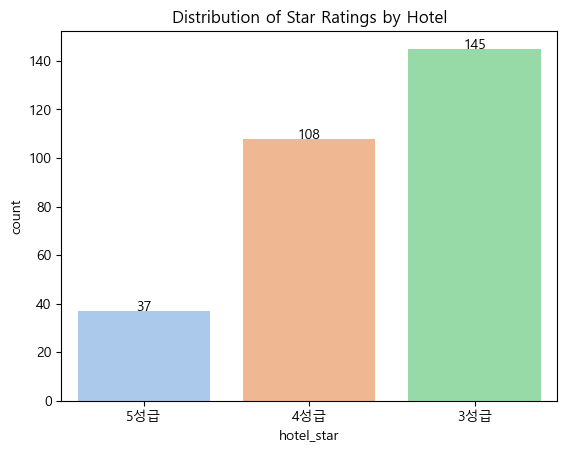

In [156]:
# 5번
sns.countplot(
    data = hotels,
    x = 'hotel_star',
    palette = 'pastel'
)
plt.title('Distribution of Star Ratings by Hotel')
plt.text(0,37,37,ha='center')
plt.text(1,108,108,ha='center')
plt.text(2,145,145,ha='center')

Text(2, 8.164, '8.164')

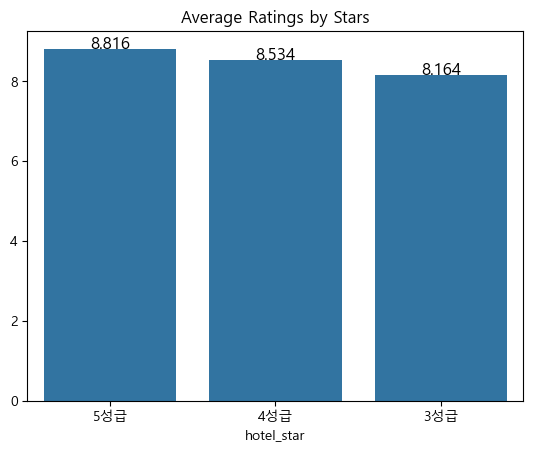

In [158]:
# 6번
mean = hotels.groupby('hotel_star')['hotel_rate'].mean().sort_values(ascending=False)

sns.barplot(
    x = mean.index,
    y = mean.values
)
plt.title('Average Ratings by Stars')
plt.text(0,8.816,8.816,fontsize=12,ha='center')
plt.text(1,8.534,8.534,fontsize=12,ha='center')
plt.text(2,8.164,8.164,fontsize=12,ha='center')

Text(0.5, 1.0, 'Average Ratings by Stars')

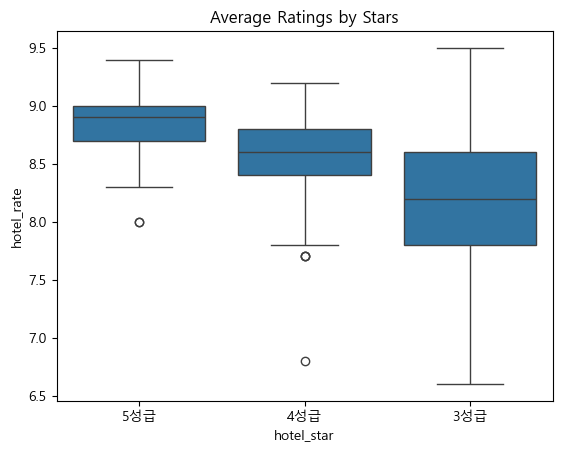

In [159]:
# 7번
sns.boxplot(
    data = hotels,
    x = 'hotel_star',
    y = 'hotel_rate'
)
plt.title('Average Ratings by Stars')

In [34]:
three_mean = hotels[hotels['hotel_star'] == '3성급']['hotel_rate']
three_mean

148    8.3
149    8.6
150    9.1
151    7.8
152    8.8
      ... 
291    8.6
292    8.3
293    6.6
294    9.5
295    8.6
Name: hotel_rate, Length: 145, dtype: float64

===================================================================================

In [20]:
# 등급 간 평균 t test

three_mean = hotels[hotels['hotel_star'] == '3성급'][['hotel_rate']]
four_mean = hotels[hotels['hotel_star'] == '4성급'][['hotel_rate']]
five_mean = hotels[hotels['hotel_star'] == '5성급'][['hotel_rate']]


test_names = ['hotel_rate']

for test_name in test_names:
    statistic,p_value = stats.levene(five_mean[test_name], four_mean[test_name])
    if p_value > 0.05:
        print(f"{test_name} p-value: {p_value}")
        print('등분산 가정 만족')
    else:
        print(f"{test_name} p-value: {p_value}")
        print('이분산 가정 만족')

hotel_rate p-value: 0.10106975762592753
등분산 가정 만족


In [21]:
for test_name in test_names:
    t_statistic,pvalue = stats.ttest_ind(
        a = five_mean[test_name],
        b = four_mean[test_name],
        alternative = 'two-sided',
        equal_var = True
)
    if pvalue<0.05:
        print(test_name, ':', pvalue)
        print('귀무가설 기각 가능')
    else:
        print(test_name, ':', pvalue)
        print('귀무가설 기각 불가능')
        
# 귀무가설 : 5성급과 4성급의 평균은 같다
# 대립가설 : 5성급과 4성급의 평균은 다르다

hotel_rate : 5.1998179433076124e-05
귀무가설 기각 가능


In [67]:
for test_name in test_names:
    statistic,p_value = stats.levene(three_mean[test_name], four_mean[test_name])
    if p_value > 0.05:
        print(f"{test_name} p-value: {p_value}")
        print('등분산 가정 만족')
    else:
        print(f"{test_name} p-value: {p_value}")
        print('이분산 가정 만족')

hotel_rate p-value: 1.8888764822298564e-06
이분산 가정 만족


In [22]:
for test_name in test_names:
    t_statistic,pvalue = stats.ttest_ind(
        a = three_mean[test_name],
        b = four_mean[test_name],
        alternative = 'two-sided',  
        equal_var = False
)
    if pvalue<0.05:
        print(test_name, ':', pvalue)
        print('귀무가설 기각 가능')
    else:
        print(test_name, ':', pvalue)
        print('귀무가설 기각 불가능')
        
# 귀무가설 : 4성급과 3성급의 평균은 같다
# 대립가설 : 4성급과 3성급의 평균은 다르다

hotel_rate : 1.2647770148157588e-08
귀무가설 기각 가능


In [71]:
for test_name in test_names:
    statistic,p_value = stats.levene(three_mean[test_name], four_mean[test_name])
    if p_value > 0.05:
        print(f"{test_name} p-value: {p_value}")
        print('등분산 가정 만족')
    else:
        print(f"{test_name} p-value: {p_value}")
        print('이분산 가정 만족')

hotel_rate p-value: 1.8888764822298564e-06
이분산 가정 만족


In [72]:
for test_name in test_names:
    t_statistic,pvalue = stats.ttest_ind(
        a = three_mean[test_name],
        b = four_mean[test_name],
        alternative = 'two-sided',
        equal_var = False
)
    if pvalue<0.05:
        print(test_name, ':', pvalue)
        print('귀무가설 기각 가능')
    else:
        print(test_name, ':', pvalue)
        print('귀무가설 기각 불가능')
        
# 귀무가설 : 5성급과 3성급의 평균은 같다
# 대립가설 : 5성급과 3성급의 평균은 다르다

hotel_rate : 1.2647770148157588e-08
귀무가설 기각 가능


===================================================================================

In [121]:
hotels['gu'] = hotels['hotel_location'].str.split(' ', expand=True)[1]


In [ ]:
hotels['gu'].value_counts()

Text(0.5, 1.0, 'Number of Hotels by District')

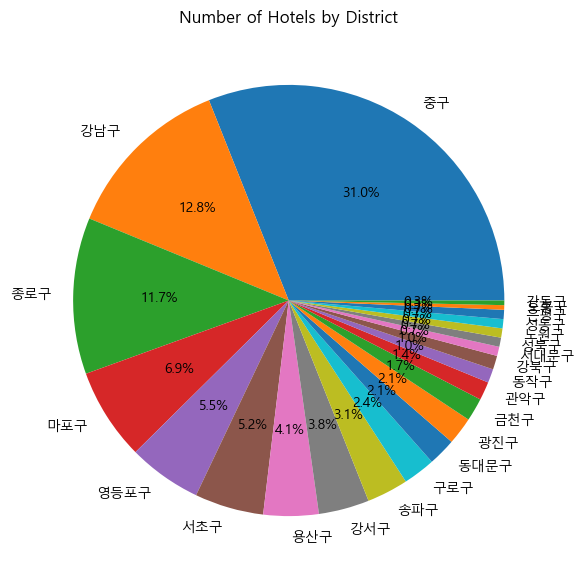

In [162]:
# 8번
plt.figure(figsize=(7,7))
plt.pie(
    hotels['gu'].value_counts(),
    labels = hotels['gu'].value_counts().index,
    autopct='%1.1f%%'
    )
plt.title('Number of Hotels by District')

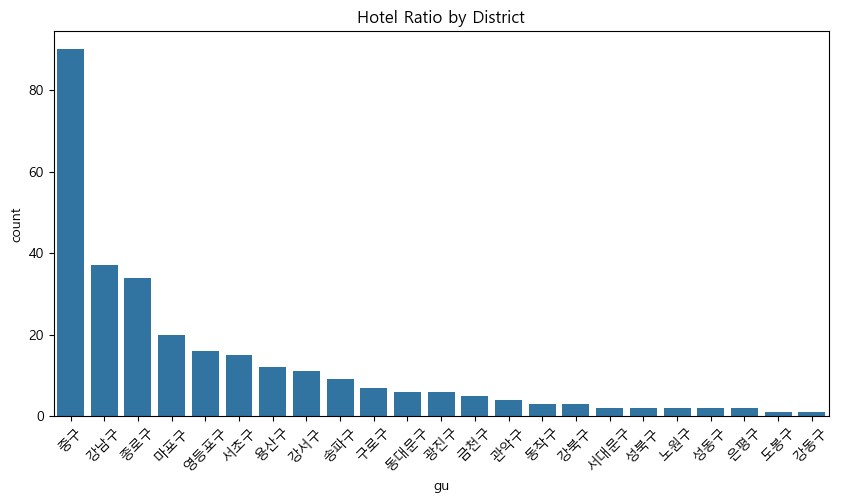

In [164]:
# 9번
plt.figure(figsize=(10,5))
sns.barplot(
    hotels['gu'].value_counts()
    )
plt.title('Hotel Ratio by District')
_=plt.xticks(rotation=45)

C:\Users\xzv22\AppData\Local\Temp\ipykernel_25876\1262818444.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\xzv22\AppData\Local\Temp\ipykernel_25876\1262818444.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\xzv22\AppData\Local\Temp\ipykernel_25876\1262818444.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0.5, 1.0, 'Number of 3-Star Hotels by District')

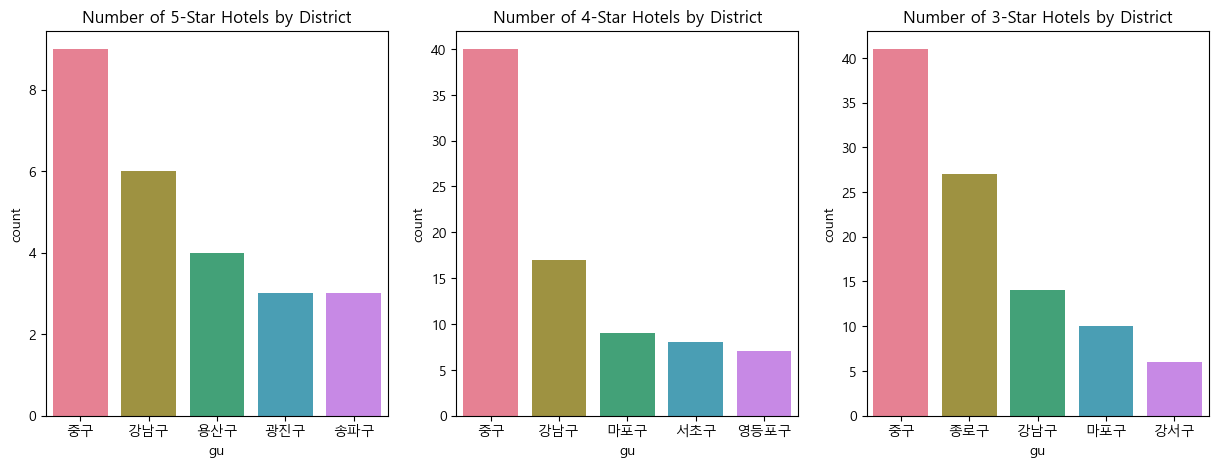

In [165]:
# 10번
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.barplot(
    hotels[hotels['hotel_star'] == '5성급']['gu'].value_counts().head(5),
    palette = 'husl'
)
plt.title('Number of 5-Star Hotels by District')

plt.subplot(1,3,2)
sns.barplot(
    hotels[hotels['hotel_star'] == '4성급']['gu'].value_counts().head(5),
    palette = 'husl'
)
plt.title('Number of 4-Star Hotels by District')

plt.subplot(1,3,3)
sns.barplot(
    hotels[hotels['hotel_star'] == '3성급']['gu'].value_counts().head(5),
    palette = 'husl'
)
plt.title('Number of 3-Star Hotels by District')

C:\Users\xzv22\AppData\Local\Temp\ipykernel_25876\810268117.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\xzv22\AppData\Local\Temp\ipykernel_25876\810268117.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


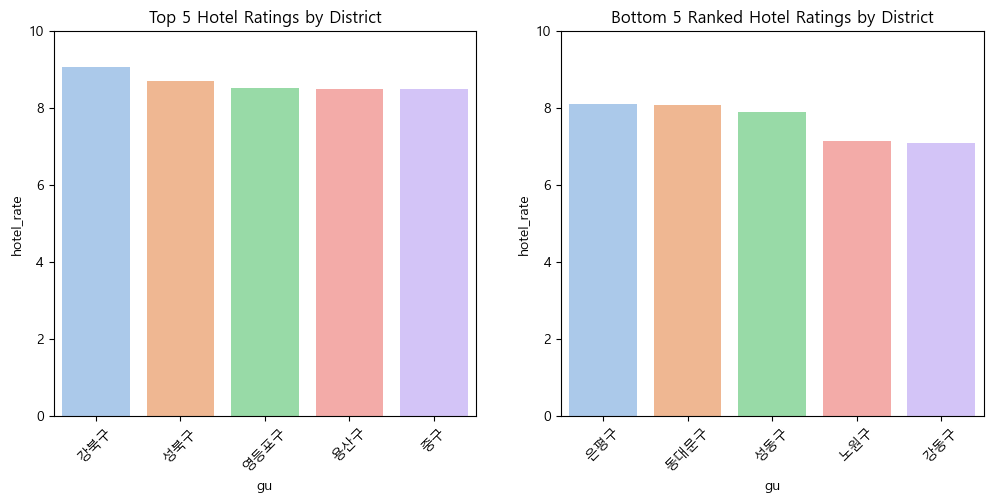

In [166]:
# 11번
gu_mean = hotels.groupby('gu')['hotel_rate'].mean().sort_values(ascending=False)
colours = ['pink','skyblue','lightgreen','orange','gold']

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.barplot(
    gu_mean[:5],
    palette = 'pastel'
)
plt.ylim(0,10)
plt.title('')
plt.title('Top 5 Hotel Ratings by District')
_=plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.barplot(
    gu_mean[-5:],
    palette = 'pastel'

)
plt.ylim(0,10)
plt.title('Bottom 5 Ranked Hotel Ratings by District')
_=plt.xticks(rotation=45)

토큰화

In [ ]:
total_reviews = sum(len(inner_list) for inner_list in hotels["review"])
print("전체 호텔 리뷰수: 115498")
print("총 호텔 수: 296")
print("결측치 제거 후 호텔 수:",len(hotels["review"]))

In [251]:
# 리뷰, 평점 분리

import ast

def extract_reviews_ratings(df):
    new_rows = []
    for index, row in df.iterrows():
        hotel_name = row['hotel_name']
        star = row['hotel_star']
        reviews = ast.literal_eval(row['review'])

        for review_item in reviews:
            rating = review_item[0]
            review = review_item[1]

            new_row = {'hotel_name': hotel_name, 'star':star, 'rating': rating, 'review': review}
            new_rows.append(new_row)

    new_df = pd.DataFrame(new_rows)
    return new_df


result_hotels = extract_reviews_ratings(hotels)

In [257]:
result_hotels = result_hotels.reset_index(drop=True)

In [ ]:
# 12 / 12-1
result_hotels[75:83]

In [259]:
# 한글 외 다른 언어 리뷰 제거

def contains_korean(text):
    for char in text:
        if '가' <= char <= '힣':
            return True
    return False


result_hotels = result_hotels[result_hotels['review'].apply(contains_korean)]

In [261]:
# 14-1
result_hotels.iloc[138]['review']

'친절한 서비스 덕분에 다음에 또 방문하고 싶어지네요 👍'

In [264]:
# 14-2
result_hotels.iloc[138]['review']

'친절한 서비스 덕분에 다음에 또 방문하고 싶어지네요 '

In [263]:
# 이모티콘 제거

for i in range(len(result_hotels)):
    result_hotels.iloc[i]['review'] = core.replace_emoji(result_hotels.iloc[i]['review'])

In [265]:
# 토큰화
# 15번
komoran = Komoran()

def tokenize(sentence):
    try:
        return komoran.nouns(sentence)
    except:
        print("예외!", sentence)
        return []

tqdm.pandas()
result_hotels["tokens"] = result_hotels["review"].progress_apply(lambda x: tokenize(x))

100%|██████████| 113781/113781 [03:28<00:00, 546.13it/s] 


In [ ]:
# 13
result_hotels.to_csv('./data/result_hotels.csv',index=False,encoding='utf-8')
result_hotels

================================================================================================================================

WordCloud

In [3]:
result_hotels = pd.read_csv('./data/result_hotels.csv')
result_hotels

hotel_name star  rating  \
0       그랜드 워커힐 서울  5성급    10.0   
1       그랜드 워커힐 서울  5성급    10.0   
2       그랜드 워커힐 서울  5성급    10.0   
3       그랜드 워커힐 서울  5성급    10.0   
4       그랜드 워커힐 서울  5성급    10.0   
...            ...  ...     ...   
113776  에이퍼스트호텔 명동  3성급     8.4   
113777  에이퍼스트호텔 명동  3성급     9.6   
113778  에이퍼스트호텔 명동  3성급    10.0   
113779  에이퍼스트호텔 명동  3성급     8.8   
113780  에이퍼스트호텔 명동  3성급     6.4   

                                                   review  \
0       오래된 곳이러는 인식이 강해 어릴 적 외에 성인이 된 후 스스로 선택해 가 본 적은...   
1       서울 시내 여러 호텔들 중에서도 클럽라운지 포함한 패키지 금액이 너무 합리적이라 가...   
2       다가올 빡쎈 하반기 일정을 대비해 나에게 선물하는 느낌으로 가을 정취를 만끽하기위해...   
3       5월 더글라스 투숙을 마지막으로오랜만에 광장동에 찾게 됩니다. 2년전 명절 차례를 ...   
4       해외여행 취소와 장마라는 복병으로 올해 휴가는 힘들겠구나 생각했습니다. 답답한 마음...   
...                                                   ...   
113776  정말깨끗한편이었어요! 지은지얼마안되서그런지, 깨끗하고향기나는호텔이었네요. 어매니티도...   
113777  7세, 10세와 함께 한 서울나들이였어요. 깔끔해서 좋았어요. 2층침대가 마음에 들...   
113778       주변에 맛집 카페 편의점 등 많고 이동하기 좋아요! 호텔도 깨끗하고 좋았습니다.   
113779  일본인 친구가 한국에 여행오게되면서 묵었는데 굉장히 깔끔하고 조용해서 편안하게 이용...   
113780  연휴라 그런지 조식도 없고, 침대 아래엔 쓰레기 한가득. 트리플 룸에서 지냈는데 정...   

                                                   tokens  
0       ['곳', '인식', '적', '외', '성인', '후', '선택', '이번', '...  
1       ['서울', '시내', '호텔', '중', '클럽', '라운지', '포함', '패키...  
2       ['하반기', '일정', '대비', '선물', '느낌', '정취', '만끽', '가...  
3       ['5월', '글라스', '투숙', '마지막', '오랜만', '광장동', '2년',...  
4       ['해외여행', '취소', '장마', '복병', '올해', '휴가', '생각', '...  
...                                                   ...  
113776  ['정말', '한편', '지', '은지', '얼마', '안', '되', '서', '...  
113777  ['세', '세', '서울', '나들이', '층', '침대', '마음', '아들',...  
113778         ['주변', '맛집', '카페', '편의점', '등', '이동', '호텔']  
113779  ['일본인', '친구', '한국', '여행', '편안', '이용', '화장실', '...  
113780  ['연휴', '그런지', '조식', '침대', '아래', '쓰레기', '트리플', ...  

[113781 rows x 5 columns]

In [4]:
# 단어 평가

tqdm.pandas()
result_hotels['tokens'] = result_hotels['tokens'].progress_apply(lambda x: eval(x))

100%|██████████| 113781/113781 [00:06<00:00, 17150.87it/s]


In [5]:
# 호텔명 기준으로 합치기

grouped_hotels = pd.DataFrame(result_hotels.groupby('hotel_name')['tokens'].agg(lambda x: sum(x, [])).reset_index())

In [7]:
# 호텔당 키워드 언급 회수

from collections import Counter,defaultdict

word_count_dict = defaultdict(Counter)

for i in range(len(grouped_hotels["hotel_name"])):
  c = Counter(grouped_hotels["tokens"][i])
  word_count_dict[grouped_hotels["hotel_name"][i]] += c

In [ ]:
word_count_dict

In [9]:
# 키워드 총 언급수

total_word_counter = Counter()
for word in word_count_dict.values():
    total_word_counter += word

In [49]:
total_word_counter

Counter({'호텔': 30415,
         '위치': 27089,
         '직원': 21522,
         '친절': 19685,
         '이용': 19467,
         '것': 17817,
         '가격': 17496,
         '방': 15526,
         '만족': 15086,
         '조식': 13417,
         '수': 12501,
         '룸': 12034,
         '시설': 11478,
         '숙소': 11047,
         '객실': 10303,
         '안': 9923,
         '때': 9344,
         '거': 8513,
         '곳': 8009,
         '대비': 7798,
         '주변': 7459,
         '침대': 7283,
         '예약': 7254,
         '생각': 6921,
         '서비스': 6826,
         '불편': 6697,
         '분': 6655,
         '성비': 6597,
         '화장실': 6403,
         '상태': 6243,
         '방문': 6230,
         '서울': 6010,
         '주차': 5956,
         '청소': 5602,
         '근처': 5600,
         '최고': 5355,
         '다음': 5339,
         '청결': 5303,
         '점': 5274,
         '정도': 5233,
         '등': 5175,
         '시간': 5106,
         '숙박': 5017,
         '체크인': 4966,
         '소리': 4948,
         '추천': 4920,
         '컨디션': 4836,
     

(-0.5, 1131.5, 607.5, -0.5)

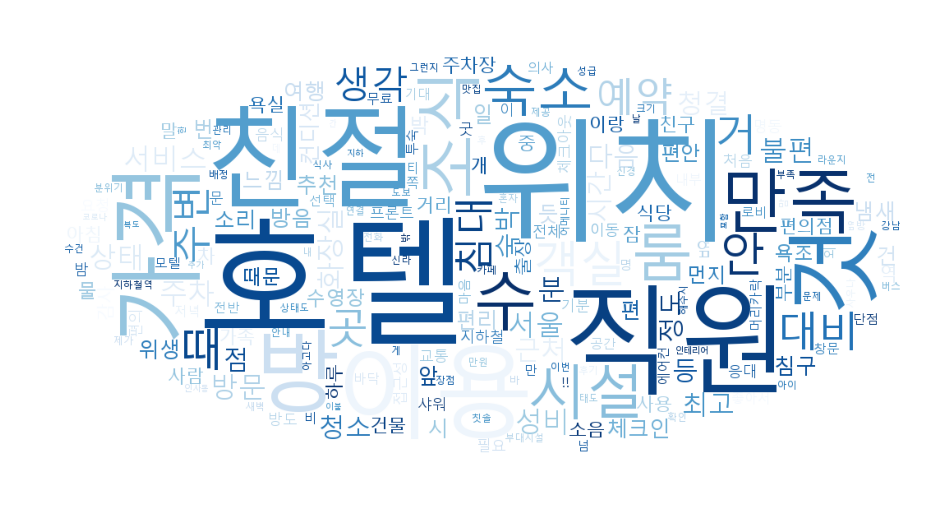

In [26]:
# 워드클라우드 시각화
# 리뷰에서 가장 많이 언급된 단어

from wordcloud import WordCloud
from PIL import Image
import numpy as np

img =Image.open("./data/hotel_logo5.png")
imgArray = np.array(img)
wordcloud = WordCloud(
    width = 10000,
    height = 400,
    font_path = r'C:\Windows\Fonts\Malgun.ttf',
    scale = 2.0,
    background_color = 'white',
    colormap = 'Blues',
    mask = imgArray
).generate_from_frequencies(total_word_counter)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis('off')

단어 선정

1. 위치 - 편의점, 주변
2. 친절 - 직원, 서비스
3. 가격 - 
4. 조식 - 
5. 시설 - 숙소,화장실, 객실, 욕조, 위생, 수건, 물 등
6. 전망 - (내가 좋아서 넣음)

In [45]:
result = defaultdict(Counter)

# Count occurrences
tqdm.pandas()
for num in range(len(result_hotels)):
    hotel_name = result_hotels['hotel_name'][num]
    tokens = result_hotels['tokens'][num]
    
    for keyword in tfidf.vocabulary_.keys():
        if keyword in tokens:
            result[keyword][hotel_name] += 1

곳: Counter({'나인트리 프리미어 호텔 인사동': 192, '도미인 서울 강남': 154, '호텔 피제이 명동': 138, '신라스테이 광화문': 127, '오라카이 청계산 호텔': 124, '나인트리 프리미어 호텔 명동 2': 109, '신라스테이 구로': 105, '호텔 스카이파크 킹스타운 동대문점': 94, '서울 올림픽 파크텔': 93, '로이넷 호텔 서울 마포': 89, '나인트리 호텔 동대문': 83, '더 스테이트 선유': 83, '호텔 파크하비오': 83, '신라스테이 서대문': 76, '더 퍼스트 스테이 호텔  )': 72, '서울앤호텔 동대문': 71, '코리아나 호텔': 70, '호텔 더 디자이너스 서울역': 70, '글래드 마포': 68, '리베라 호텔': 66, '노보텔 앰배서더 서울 동대문 호텔 & 레지던스': 63, '시그니엘 서울': 62, '프레지던트 호텔': 62, '워커힐 더글라스 하우스': 61, '오라카이 대학로 호텔': 61, '스테이 호텔 강남': 61, '서울신라호텔': 60, '프렌들리 DH 네상스 호텔 바이 민드럼 그룹': 58, '롯데호텔 월드': 57, '롯데시티호텔 구로': 57, '호텔 더 디자이너스 홍대': 57, '스위스 그랜드 호텔 서울': 56, '메이필드 호텔 서울': 56, '신라스테이 마포': 55, '신라스테이 역삼': 55, 'ENA 스위트 호텔 남대문': 55, '신라스테이 서초': 54, '서울 가든 호텔': 53, '그랜드 워커힐 서울': 52, '오클라우드 호텔 강남 )': 52, '글래드 여의도': 50, '토요코 인 강남 서울': 50, '엠디 호텔 독산  )': 49, '글래드 강남 코엑스 센터': 49, '아만티 호텔 서울': 47, '켄싱턴호텔 여의도': 44, '오리엔스 호텔 앤 레지던스 명동': 43, '롯데시티호텔 마포': 43, '더케이호텔 서울': 42, '호텔 엠펠리체': 42, '콘래드 서울': 41, '노보텔 앰배서더 서울 용산': 41, '그랜드 하얏트

Text(0.5, 1.0, 'Location')

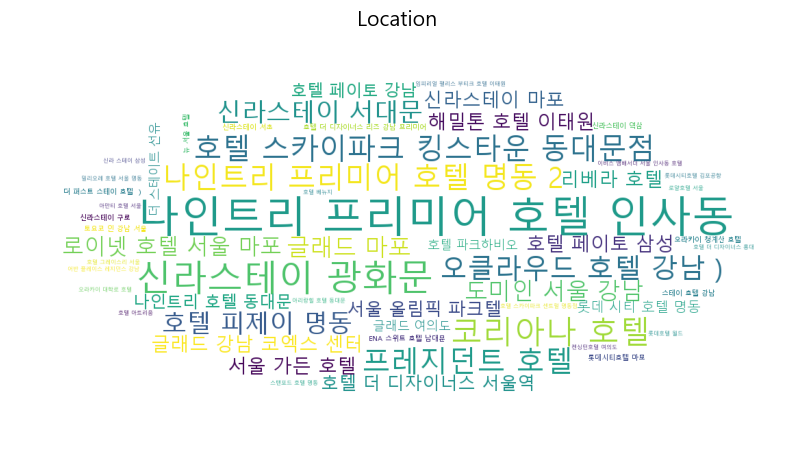

In [78]:
# 1번 : 위치

img =Image.open("./data/hotel_logo5.png")
imgArray = np.array(img)
wordcloud = WordCloud(
    width = 10000,
    height = 400,
    font_path = r'C:\Windows\Fonts\Malgun.ttf',
    scale = 2.0,
    background_color = 'white',
    colormap = 'viridis',
    mask = imgArray
).generate_from_frequencies(result['위치'])
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Location',fontsize = 15)

Text(0.5, 1.0, 'Customer Service')

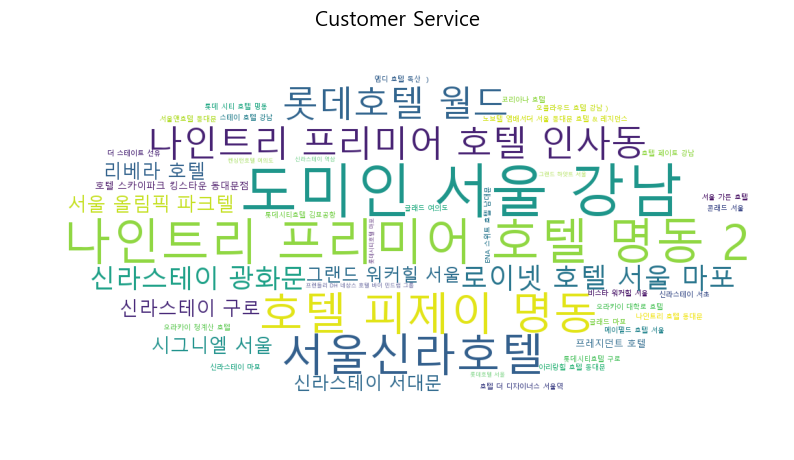

In [79]:
# 2번 : 친절

img =Image.open("./data/hotel_logo5.png")
imgArray = np.array(img)
wordcloud = WordCloud(
    width = 10000,
    height = 400,
    font_path = r'C:\Windows\Fonts\Malgun.ttf',
    scale = 2.0,
    background_color = 'white',
    colormap = 'viridis',
    mask = imgArray
).generate_from_frequencies(result['친절'])
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Customer Service',fontsize = 15)

Text(0.5, 1.0, 'Price')

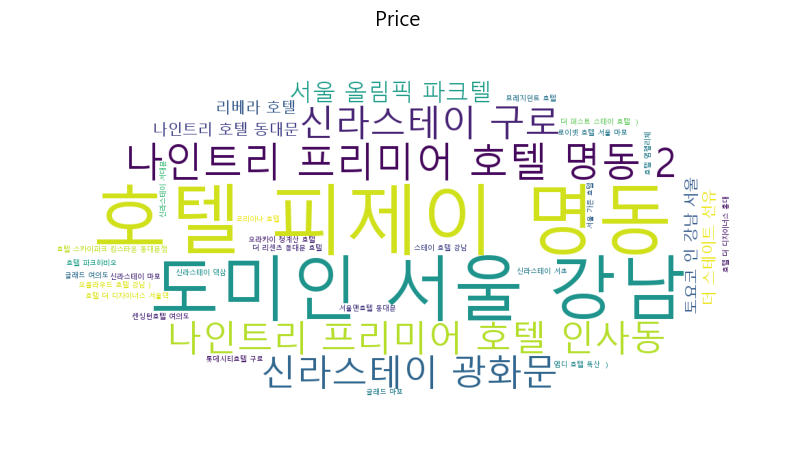

In [80]:
# 3번 : 가격

img =Image.open("./data/hotel_logo5.png")
imgArray = np.array(img)
wordcloud = WordCloud(
    width = 10000,
    height = 400,
    font_path = r'C:\Windows\Fonts\Malgun.ttf',
    scale = 2.0,
    background_color = 'white',
    colormap = 'viridis',
    mask = imgArray
).generate_from_frequencies(result['가격'])
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Price',fontsize = 15)

Text(0.5, 1.0, 'Breakfast')

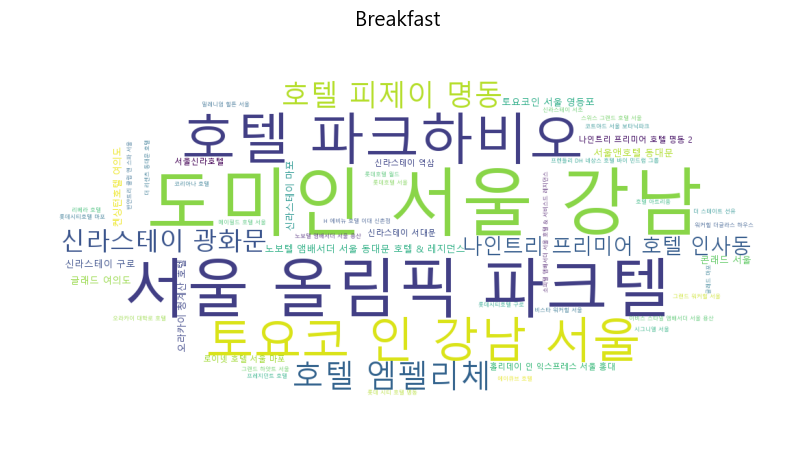

In [81]:
# 4번 : 조식

img =Image.open("./data/hotel_logo5.png")
imgArray = np.array(img)
wordcloud = WordCloud(
    width = 10000,
    height = 400,
    font_path = r'C:\Windows\Fonts\Malgun.ttf',
    scale = 2.0,
    background_color = 'white',
    colormap = 'viridis',
    mask = imgArray
).generate_from_frequencies(result['조식'])
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Breakfast',fontsize = 15)

Text(0.5, 1.0, 'Room Quality')

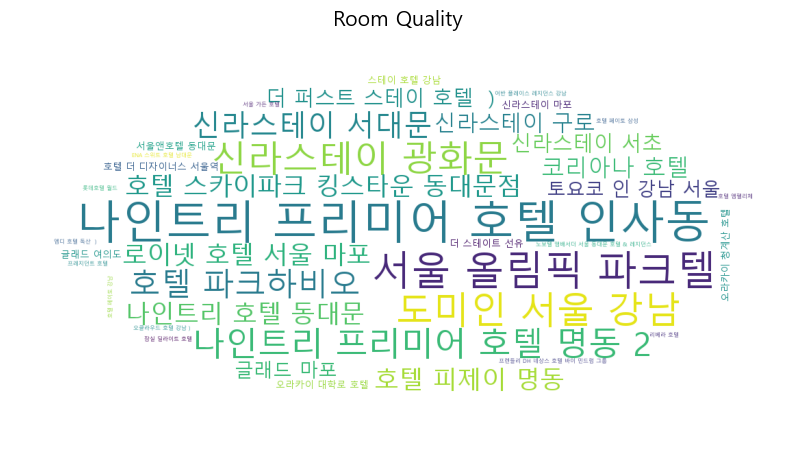

In [82]:
# 5번 : 숙소

img =Image.open("./data/hotel_logo5.png")
imgArray = np.array(img)
wordcloud = WordCloud(
    width = 10000,
    height = 400,
    font_path = r'C:\Windows\Fonts\Malgun.ttf',
    scale = 2.0,
    background_color = 'white',
    colormap = 'viridis',
    mask = imgArray
).generate_from_frequencies(result['숙소'])
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Room Quality',fontsize = 15)

Text(0.5, 1.0, 'View')

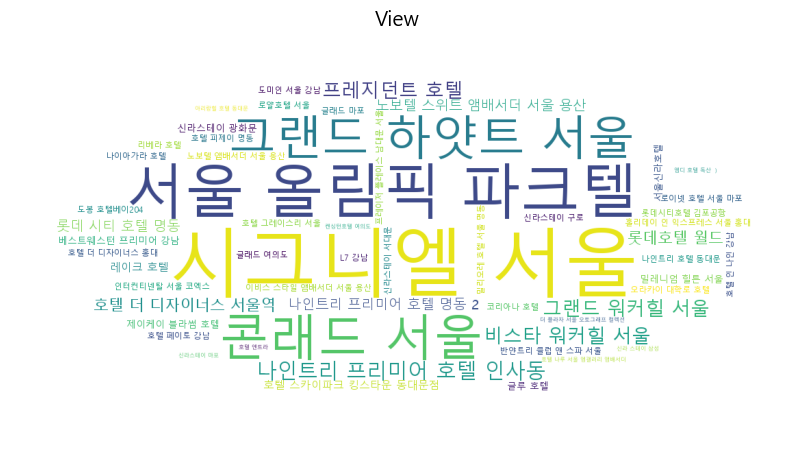

In [83]:
# 6번 : 전망

img =Image.open("./data/hotel_logo5.png")
imgArray = np.array(img)
wordcloud = WordCloud(
    width = 10000,
    height = 400,
    font_path = r'C:\Windows\Fonts\Malgun.ttf',
    scale = 2.0,
    background_color = 'white',
    colormap = 'viridis',
    mask = imgArray
).generate_from_frequencies(result['전망'])
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('View',fontsize = 15)

==============================================================================

TF - IDF 추천시스템


In [15]:
# 전체 토큰 벡터화

from sklearn.feature_extraction.text import TfidfVectorizer

def dummy_func(doc):
  return doc

#이미 토근화 되어 있어 그냥 아무것도 없는 dummy_func전달
tfidf = TfidfVectorizer(
  analyzer="word",
  tokenizer=dummy_func,
  preprocessor=dummy_func,
  token_pattern=None
)

# 토큰 백터화 진행
tfidf_csr_matrix = tfidf.fit_transform(grouped_hotels["tokens"])

# 백터화 한 토큰 수 출력
print("tfidf.vocabulary_:",len(tfidf.vocabulary_))

tfidf.vocabulary_: 15595


In [7]:
# 쿼리 유사도 추천 시스템

komoran = Komoran()

# input 문장 토큰화 함수
def tokenize(sentence):
  tokens = komoran.pos(sentence)
  nouns =[text for text,tag in tokens if tag in ("NNP","NNG")]
  return nouns

In [33]:
# 호텔 추천 함수
def search(query):
    # 쿼리(인풋) 토큰화
    query_nouns = tokenize(query)
    
    # 벡터화
    query_tfidf = tfidf.transform([query_nouns])
    
    # 코사인 유사도 검사
    similarities = cosine_similarity(query_tfidf,tfidf_csr_matrix).flatten()
    
    # 상위 5 선정
    top_similarities = sorted(similarities,reverse=True)[:5]
    top_indicies = similarities.argsort()[-5:][::-1]
    top_titles = [grouped_hotels.iloc[i]['hotel_name'] for i in top_indicies]
    
    for i,(similarity, name) in enumerate(zip(top_similarities,top_titles)):
        print(f'{i+1}순위 : {name}')

In [20]:
query = '종로에서 조식 맛있고 지하철역과 가까운 곳'

In [21]:
tokenize(query)

['종로', '조식', '지하철역', '곳']

In [34]:
search(query)

1순위 : 호텔 아트리움
2순위 : 르몽호텔
3순위 : 호텔 더 디자이너스 종로
4순위 : 호텔 엠펠리체
5순위 : 홀리데이 인 익스프레스 서울 홍대


=========================================================================================================
word2vec 추천시스템

In [195]:
from gensim.models.callbacks import CallbackAny2Vec


loss_list = []

class MonitorCallback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 1   # 전체 학습
        self.prev_loss = 0
        loss_list = []
        
    def on_epoch_end(self,model):
        cum_loss = model.get_latest_training_loss()
        current_loss = cum_loss - self.prev_loss
        loss_list.append(current_loss)
        print(f'epoch:{self.epoch} loss : {current_loss}')
        self.prev_loss = cum_loss
        self.epoch += 1

In [196]:
from gensim.models import Word2Vec

model = Word2Vec(
    epochs = 5, # 5번 반복 학습
    sentences = grouped_hotels['tokens'],
    vector_size = 32, # 단어 32차원 학습
    window = 10, # 양쪽 단어 수
    min_count = 50, # 단어 최소 등장 횟수
    sg = 1,  # skip gram
    workers = 4,  # cpu 코어 배정
    callbacks = [MonitorCallback()],
    compute_loss = True
)

epoch:1 loss : 6040040.5
epoch:2 loss : 4863170.5
epoch:3 loss : 4460464.0
epoch:4 loss : 4653811.0
epoch:5 loss : 4827358.0


In [198]:
model.wv.most_similar('야경')

[('전망', 0.9394378066062927),
 ('경치', 0.9097149968147278),
 ('풍경', 0.8938903212547302),
 ('감상', 0.8782477974891663),
 ('한강', 0.8478686213493347),
 ('전경', 0.8448176383972168),
 ('남산타워', 0.835970938205719),
 ('환상', 0.8203797340393066),
 ('한눈', 0.8132777810096741),
 ('창밖', 0.808016836643219)]